# Variational Autoencoder Using MNIST

## 1. Setup

In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__
# '1.13.0+cu117'

'1.13.0+cu117'

In [3]:
# Get info of all GPU devices
!nvidia-smi

Tue Jul 18 16:29:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:22:00.0 Off |                  N/A |
|  0%   38C    P8              14W / 170W |  10410MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
# Set environment variable with possible device ids
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])
# Set device: 0 or 1
# NOTE: indices are not necessarily the ones shown by nvidia-smi
# We need to try them with the cell below
torch.cuda.set_device("cuda:0")

0,1


In [7]:
# Check that the selected device is the desired one
print("Torch version?", torch.__version__)
print("Torchvision version?", torchvision.__version__)
print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())
print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))
x = torch.rand(5, 3)
print(x)

Torch version? 1.13.0+cu117
Torchvision version? 0.14.0+cu117
Is cuda available? True
Is cuDNN version: 8500
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  NVIDIA GeForce RTX 3060
tensor([[0.6240, 0.3281, 0.2469],
        [0.7465, 0.1057, 0.3350],
        [0.0840, 0.4229, 0.6546],
        [0.2505, 0.9980, 0.2540],
        [0.3543, 0.1924, 0.3401]])


## 2. Variational Autoencoder

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mu
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # logvar

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar # z:embedding, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)  # generate epsilon from standard normal distribution
        return mu + eps*std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        #mu, logvar = self.encode(x.view(-1, 784))
        z, mu, logvar = self.encode(x)
        x_recons = self.decode(z)
        return x_recons, z, mu, logvar

In [9]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    #mse_loss = nn.MSELoss()
    #MSE = mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
    #return MSE + KLD

In [10]:
def train(model, train_loader, optimizer, device, num_epochs):
    model.train()
    train_loss_history = []

    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            data = data.view(data.shape[0], -1)  # (B, 1, 28, 28) -> (B, 1*28*28)
            reconstructed_batch, z, mu, logvar = model(data)

            # Calculate Loss using the custom loss function
            loss = vae_loss(reconstructed_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        train_loss /= len(train_loader.dataset)
        train_loss_history.append(train_loss)

        print(f'====> Epoch: {epoch} Average loss: {train_loss:.4f}')

    return train_loss_history

In [11]:
def plot_loss_history(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.show()

In [44]:
def plot_original_vs_reconstructed(original, reconstructed):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(original.squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(reconstructed.squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

====> Epoch: 0 Average loss: 146.1010
====> Epoch: 1 Average loss: 115.7822
====> Epoch: 2 Average loss: 111.5273
====> Epoch: 3 Average loss: 109.5435
====> Epoch: 4 Average loss: 108.3582
====> Epoch: 5 Average loss: 107.4979
====> Epoch: 6 Average loss: 106.9281
====> Epoch: 7 Average loss: 106.4159
====> Epoch: 8 Average loss: 106.0647
====> Epoch: 9 Average loss: 105.7027
====> Epoch: 10 Average loss: 105.4385
====> Epoch: 11 Average loss: 105.1402
====> Epoch: 12 Average loss: 104.9577
====> Epoch: 13 Average loss: 104.7729
====> Epoch: 14 Average loss: 104.5147
====> Epoch: 15 Average loss: 104.4389
====> Epoch: 16 Average loss: 104.2098
====> Epoch: 17 Average loss: 104.1141
====> Epoch: 18 Average loss: 103.9417
====> Epoch: 19 Average loss: 103.8233
====> Epoch: 20 Average loss: 103.6801
====> Epoch: 21 Average loss: 103.5797
====> Epoch: 22 Average loss: 103.4933
====> Epoch: 23 Average loss: 103.4219
====> Epoch: 24 Average loss: 103.2721
====> Epoch: 25 Average loss: 103.1

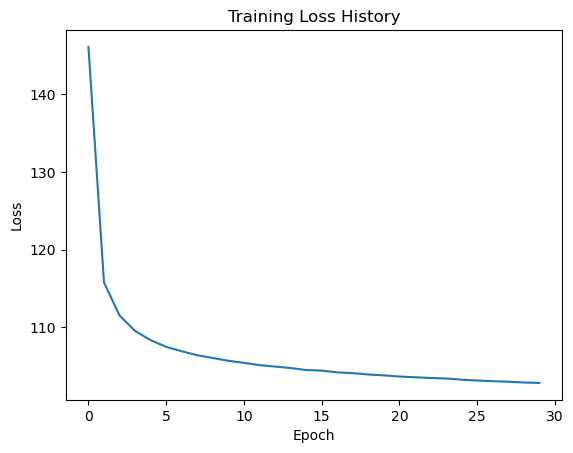

In [11]:
# Instantiate objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# MNIST Dataset
train_dataset = datasets.MNIST(root='../datasets/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='../datasets/', train=False, transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# TRAIN
#torch.autograd.set_detect_anomaly(True)
train_loss_history = train(vae, train_loader, optimizer, device, num_epochs=30)
plot_loss_history(train_loss_history)

In [12]:
# Define a test loader iterator
dataiter = iter(test_loader)

(64, 1, 28, 28)
(64, 1, 28, 28)


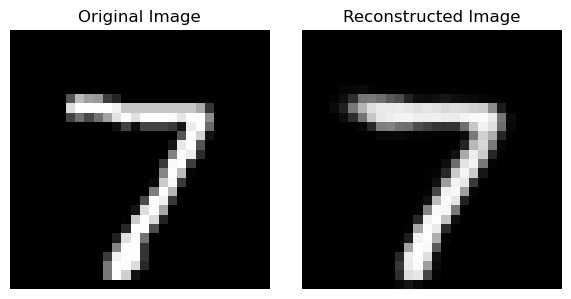

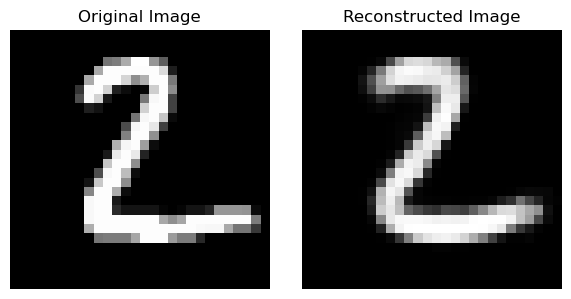

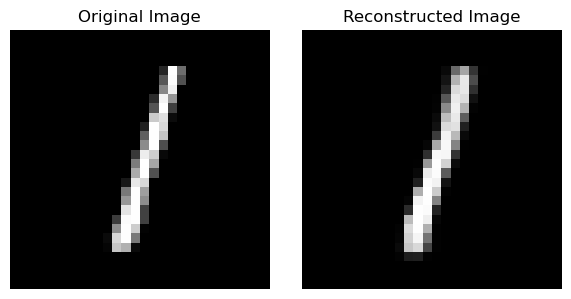

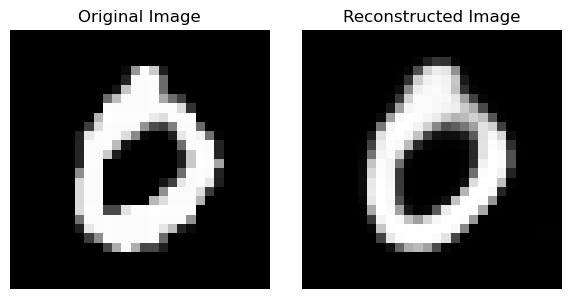

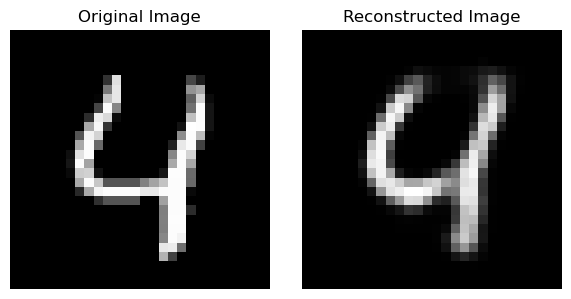

In [13]:
# Get a batch of original images
images, _ = next(dataiter)

# Pass the images through the VAE to get the reconstructed images
images = images.to(device)
images = images.view(images.shape[0], -1)  # (B, 1, 28, 28) -> (B, 1*28*28)
reconstructed_images, z, mu, logvar = vae(images)
images = images.view(images.shape[0], 1, 28, 28)
reconstructed_images = reconstructed_images.view(reconstructed_images.shape[0], 1, 28, 28)
reconstructed_images = reconstructed_images.cpu().detach().numpy()
images = images.cpu().detach().numpy()

print(images.shape)
print(reconstructed_images.shape)

# Plot original vs reconstructed images
for i in range(5):
    plot_original_vs_reconstructed(images[i], reconstructed_images[i])

## 3. Variational Autoencoder with Contrastive Loss

In [13]:
# Configuration class
class Config:
    def __init__(self):
        self.learning_rate = 0.001
        self.num_epochs = 30
        self.batch_size = 64
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

In [18]:
class VAEWithContrastiveLoss(VAE):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, pair=True):
        super(VAEWithContrastiveLoss, self).__init__(input_dim, hidden_dim, latent_dim)
        self.pair = True
        
    def compute_contrastive_loss(self, embedding1, embedding2, same_labels, margin=1.0):
        # Euclidean Distance
        #distance = F.pairwise_distance(embedding1, embedding2)
        #loss = torch.mean((1 - same_labels) * torch.pow(distance, 2) +
        #                  same_labels * torch.pow(torch.clamp(margin - distance, min=0.0), 2))
        # Cosine Similarity
        similarity = F.cosine_similarity(embedding1, embedding2)
        loss = torch.mean((1 - same_labels) * torch.pow(1 - similarity, 2) +
                          same_labels * torch.pow(torch.clamp(similarity - margin, min=0.0), 2))
        return loss

    def vae_loss(self, recon_x, x, mu, logvar):
        reconstruction_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return reconstruction_loss + kl_divergence

    def compute_total_loss(self, data1, data2, recon_x1, recon_x2, z1, z2, mu1, mu2, logvar1, logvar2, same_labels, margin=1.0, loss_weights=(1.0, 1.0, 1.0)):
        reconstruction_loss1 = self.vae_loss(recon_x1, data1, mu1, logvar1)
        reconstruction_loss2 = self.vae_loss(recon_x2, data2, mu2, logvar2)
        contrastive_loss = self.compute_contrastive_loss(z1, z2, same_labels, margin)
        return (
            loss_weights[0] * reconstruction_loss1
            + loss_weights[1] * reconstruction_loss2
            + loss_weights[2] * contrastive_loss
        )

    def forward(self, x):
        if self.pair:
            # We expect x to be a list of two views
            # We concatenate both views to be one large batch
            # of size 2*batch_size, i.e., (2*B, C, W, H)
            x = torch.cat(x, dim=0)
        
        z, mu, logvar = self.encode(x)
        x_recons = self.decode(z)

        return x_recons, z, mu, logvar

In [19]:
# Dataset generator class
class PairDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.pairs = self._make_pairs()

    def _make_pairs(self):
        # initialize an empty list to hold the image pairs and labels
        pairs = []

        # calculate the total number of classes present in the dataset
        # and then build a list of indexes for each class label that
        # provides the indexes for all examples with a given label
        # NOTE self.dataset.dataset accesses to the entire dataset
        # self.dataset.indices contains the indices of the Subset/current split
        #num_classes = len(np.unique(self.dataset.dataset.targets[self.dataset.indices]))
        num_classes = len(np.unique(self.dataset.dataset.targets)) # classes in ENTIRE dataset
        # Indices per class in SUBSET
        indices = [np.where(self.dataset.dataset.targets[self.dataset.indices] == i)[0] for i in range(num_classes)]
        # Negative indices per class in SUBSET: indices of images of different class
        neg_indices = [np.where(self.dataset.dataset.targets[self.dataset.indices] != i)[0] for i in range(num_classes)]

        # loop over all images
        for idx_a in range(len(self.dataset)):
            # grab the current image and label belonging to the current iteration
            _, label = self.dataset[idx_a]

            # randomly pick an image that belongs to the *same* class label
            idx_b = np.random.choice(indices[label])
            pos_image_idx = idx_b

            # prepare a positive pair and update the pairs list with the indices and label
            pairs.append((idx_a, pos_image_idx, 1))

            # grab the indices for each of the class labels *not* equal to the current label
            # and randomly pick an image corresponding to a label *not* equal to the current label
            #neg_indices = np.where(self.dataset.targets != label)[0]
            #neg_indices = np.where(self.dataset.dataset.targets != label)[0]
            #neg_image_idx = np.random.choice(neg_indices)
            neg_image_idx = np.random.choice(neg_indices[label])

            # prepare a negative pair of images and update the pairs list with the indices and label
            pairs.append((idx_a, neg_image_idx, 0))

        return pairs

    def __getitem__(self, index):
        img1_idx, img2_idx, label = self.pairs[index]
        img1, label1 = self.dataset[img1_idx]
        img2, label2 = self.dataset[img2_idx]
        assert (label1 == label2) == bool(label)
        same_class = torch.tensor(int(label1 == label2), dtype=torch.float32)
        return img1, img2, same_class
    
    def __len__(self):
        return len(self.pairs)

In [62]:
def plot_original_vs_reconstructed(original, reconstructed):
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    axes[0].imshow(original.squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(reconstructed.squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_similarity(data1, data2, similarity):
    fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    # Plot first image
    axs[0].imshow(data1.squeeze(), cmap='gray')
    axs[0].axis('off')
    # Plot second image
    axs[1].imshow(data2.squeeze(), cmap='gray')
    axs[1].axis('off')
    # Set title with similarity value
    axs[1].set_title(f'Similarity: {similarity:.4f}', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_embeddings(z1, z2):
    plt.figure(figsize=(4, 2))
    dimensions = z1.shape[0]
    x = np.arange(dimensions)  # x-axis values
    # Plot bar chart for z1
    plt.bar(x, z1, alpha=0.7, label='z1')
    # Plot bar chart for z2 with a slight shift
    plt.bar(x, z2, alpha=0.7, label='z2', width=0.4, align='edge')
    plt.tick_params(axis='both', which='both', bottom=False, top=False,
                    labelbottom=False, left=False, right=False, labelleft=False)
    plt.xlabel('Dimension')
    #plt.ylabel('Value')
    #plt.title('Embedding Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
# Load MNIST dataset
mnist_dataset = datasets.MNIST(root='../datasets/', train=True, download=True, transform=transforms.ToTensor())
print("Dataset obtained!")

# Split the dataset into train, validation, and test sets
train_size = int(0.75 * len(mnist_dataset))
val_size = int(0.1 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(mnist_dataset, [train_size, val_size, test_size])
print("Dataset splits created!")

# Create PairDataset for each split
train_dataset = PairDataset(train_dataset)
val_dataset = PairDataset(val_dataset)
test_dataset = PairDataset(test_dataset)

# Create DataLoader for each split
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
print("Dataset loaders created!")

Dataset obtained!
Dataset splits created!
Dataset loaders created!


In [21]:
model = VAEWithContrastiveLoss().to(config.device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

In [22]:
test_img1, test_img2, same_labels = next(iter(test_loader))
test_img1, test_img2, same_labels = test_img1.to(config.device), test_img2.to(config.device), same_labels.to(config.device)

In [23]:
print(test_img1.shape)
print(test_img2.shape)
print(same_labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [24]:
reconstructed_batch, z, mu, logvar = model([test_img1.view(test_img1.shape[0], -1),
                                            test_img2.view(test_img2.shape[0], -1)])

In [25]:
print(reconstructed_batch.shape)
print(z.shape)
print(mu.shape)
print(logvar.shape)

torch.Size([128, 784])
torch.Size([128, 20])
torch.Size([128, 20])
torch.Size([128, 20])


In [26]:
def train(model, train_loader, optimizer, device, num_epochs):
    model.train()
    train_loss_history = []

    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data1, data2, same_labels) in enumerate(train_loader):
            data1, data2 = data1.to(device), data2.to(device)
            same_labels = same_labels.to(device)
            optimizer.zero_grad()

            data1 = data1.view(data1.shape[0], -1)  # (B, 1, 28, 28) -> (B, 1*28*28)
            data2 = data2.view(data2.shape[0], -1)  # (B, 1, 28, 28) -> (B, 1*28*28)
            same_labels = same_labels.view(same_labels.shape[0], -1)

            #reconstructed_data1, z1, mu1, logvar1 = model(data1)
            #reconstructed_data2, z2, mu2, logvar2 = model(data2)
            reconstructed_data, z, mu, logvar = model([data1, data2])
            reconstructed_data1, reconstructed_data2 = torch.split(reconstructed_data, reconstructed_data.shape[0]//2, dim=0)
            z1, z2 = torch.split(z, z.shape[0]//2, dim=0)
            mu1, mu2 = torch.split(mu, mu.shape[0]//2, dim=0)
            logvar1, logvar2 = torch.split(logvar, logvar.shape[0]//2, dim=0)
            
            # Calculate the total loss: reconstruction of each batch pair side + KL loss + Triplet loss
            loss = model.compute_total_loss(data1, data2,
                                            reconstructed_data1, reconstructed_data2,
                                            z1, z2,
                                            mu1, mu2,
                                            logvar1, logvar2,
                                            same_labels)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        train_loss /= len(train_loader.dataset)
        train_loss_history.append(train_loss)

        print(f'====> Epoch: {epoch} Average loss: {train_loss:.4f}')

    return train_loss_history

====> Epoch: 0 Average loss: 270.1706
====> Epoch: 1 Average loss: 221.7677
====> Epoch: 2 Average loss: 215.7878
====> Epoch: 3 Average loss: 212.8690
====> Epoch: 4 Average loss: 211.0463
====> Epoch: 5 Average loss: 209.7479
====> Epoch: 6 Average loss: 208.7165
====> Epoch: 7 Average loss: 207.8822
====> Epoch: 8 Average loss: 207.1968
====> Epoch: 9 Average loss: 206.5978
====> Epoch: 10 Average loss: 206.1416
====> Epoch: 11 Average loss: 205.7049
====> Epoch: 12 Average loss: 205.2120
====> Epoch: 13 Average loss: 204.8935
====> Epoch: 14 Average loss: 204.5499
====> Epoch: 15 Average loss: 204.2640
====> Epoch: 16 Average loss: 203.9881
====> Epoch: 17 Average loss: 203.7373
====> Epoch: 18 Average loss: 203.5072
====> Epoch: 19 Average loss: 203.3189
====> Epoch: 20 Average loss: 203.0427
====> Epoch: 21 Average loss: 202.8704
====> Epoch: 22 Average loss: 202.7313
====> Epoch: 23 Average loss: 202.5412
====> Epoch: 24 Average loss: 202.3522
====> Epoch: 25 Average loss: 202.1

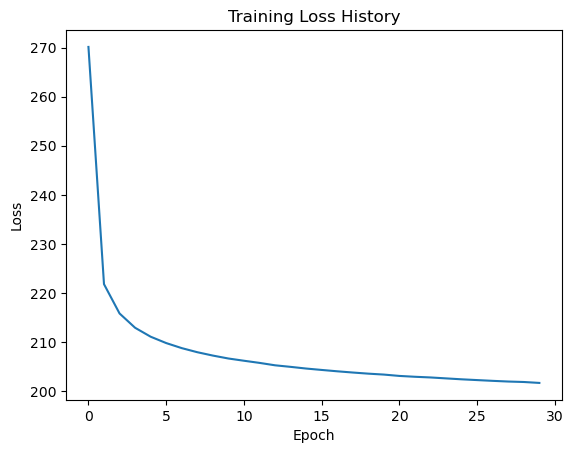

In [27]:
# TRAIN
#torch.autograd.set_detect_anomaly(True)
train_loss_history = train(model, train_loader, optimizer, device=config.device, num_epochs=config.num_epochs)
plot_loss_history(train_loss_history)

In [28]:
# Define a test loader iterator
dataiter = iter(test_loader)

(20,)


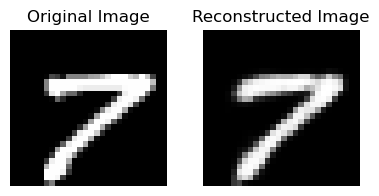

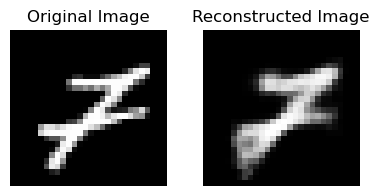

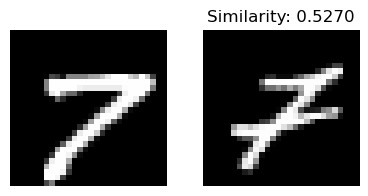

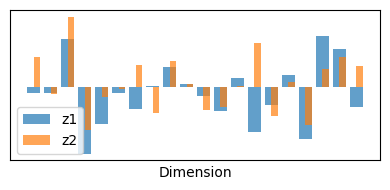

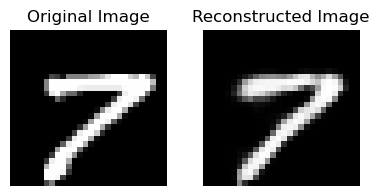

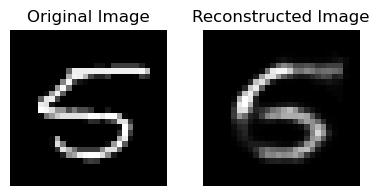

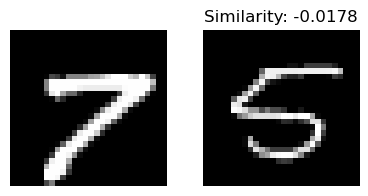

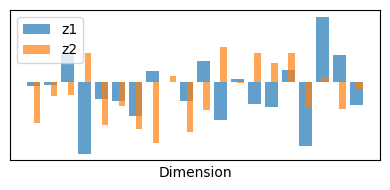

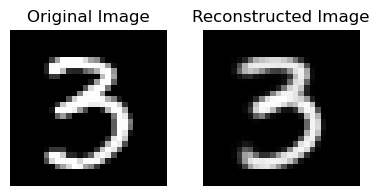

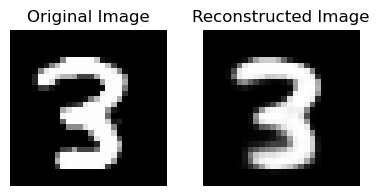

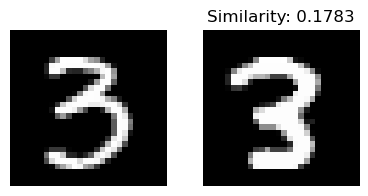

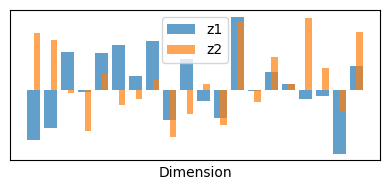

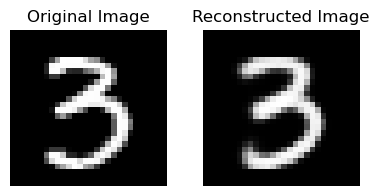

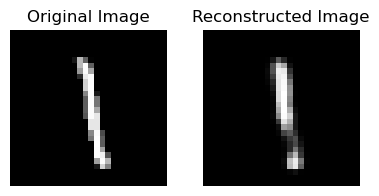

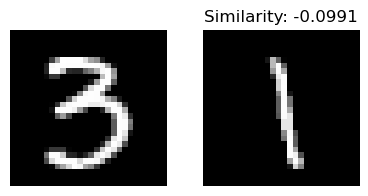

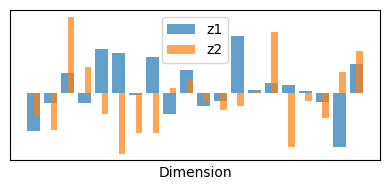

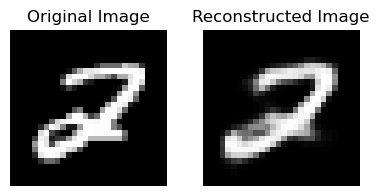

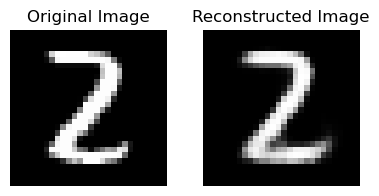

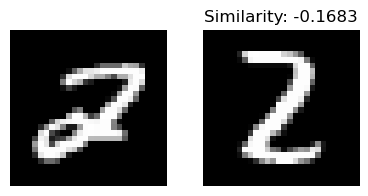

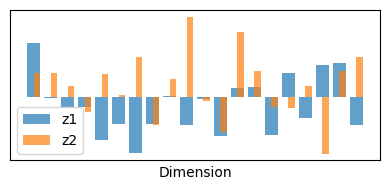

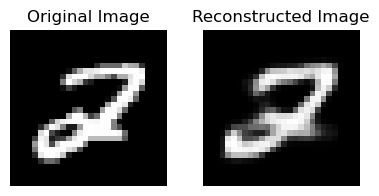

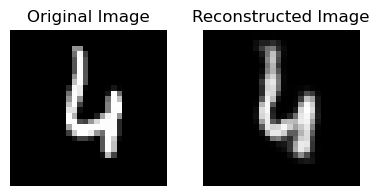

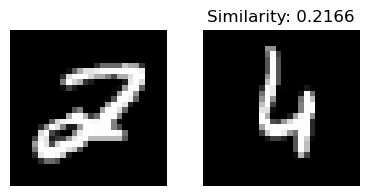

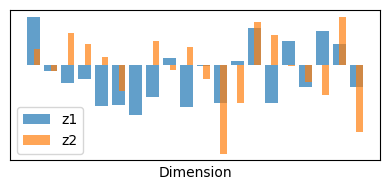

In [63]:
# Get a batch of original images
data1, data2, _ = next(dataiter)  # Get both sides of the pairs

# Pass the images through the VAE to get the reconstructed images
data1 = data1.to(config.device)
data2 = data2.to(config.device)
data1 = data1.view(data1.shape[0], -1)  # (B, 1, 28, 28) -> (B, 1*28*28)
data2 = data2.view(data2.shape[0], -1)  # (B, 1, 28, 28) -> (B, 1*28*28)

# Switch off concatenation of pair batches
model.pair = False
model.eval()
with torch.no_grad():
    reconstructed_data1, z1, mu1, logvar1 = model(data1)
    reconstructed_data2, z2, mu2, logvar2 = model(data2)

data1 = data1.view(data1.shape[0], 1, 28, 28)
data2 = data2.view(data2.shape[0], 1, 28, 28)
reconstructed_data1 = reconstructed_data1.view(reconstructed_data1.shape[0], 1, 28, 28)
reconstructed_data2 = reconstructed_data2.view(reconstructed_data2.shape[0], 1, 28, 28)
reconstructed_data1 = reconstructed_data1.cpu().detach().numpy()
reconstructed_data2 = reconstructed_data2.cpu().detach().numpy()
data1 = data1.cpu().detach().numpy()
data2 = data2.cpu().detach().numpy()

#print(data1.shape)
#print(reconstructed_data1.shape)
#print(data2.shape)
#print(reconstructed_data2.shape)

# Compute cosine similarity for each pair
cos_sim = F.cosine_similarity(z1, z2, dim=1)

z1 = z1.cpu().detach().numpy()
z2 = z2.cpu().detach().numpy()
print(z1[0].shape)

# Plot original vs reconstructed images
for i in range(6):
    plot_original_vs_reconstructed(data1[i], reconstructed_data1[i])
    plot_original_vs_reconstructed(data2[i], reconstructed_data2[i])
    plot_similarity(data1[i], data2[i], cos_sim[i])
    plot_embeddings(z1[i], z2[i])